In [ ]:
############################################################### Transform Coding (using DCT for forward transform) #############################################################

In [48]:
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

In [49]:
def dct2(block):
  return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
  return idct(idct(block.T, norm='ortho').T, norm='ortho')

def encode_image(image, block_size=8, quantization_factor=10):
  height, width = image.shape
  encoded_image = np.zeros_like(image, dtype=np.int32)

  for i in range(0, height, block_size):
    for j in range(0, width, block_size):
      block = image[i:i+block_size, j:j+block_size]
      dct_coefficients = dct2(block)
      quantized_coefficients = np.round(dct_coefficients / quantization_factor)
      encoded_image[i:i+block_size, j:j+block_size] = quantized_coefficients

  return encoded_image

def decode_image(encoded_image, block_size=8, quantization_factor=10):
  height, width = encoded_image.shape
  decoded_image = np.zeros_like(encoded_image, dtype=np.float32)

  for i in range(0, height, block_size):
    for j in range(0, width, block_size):
      quantized_coefficients = encoded_image[i:i+block_size, j:j+block_size]
      dct_coefficients = quantized_coefficients * quantization_factor
      decoded_image[i:i+block_size, j:j+block_size] = idct2(dct_coefficients)

  return decoded_image

def calculate_rmse(original_image, reconstructed_image):
  return np.sqrt(np.mean((original_image - reconstructed_image)**2))

In [50]:
# Load a grayscale image
image = plt.imread('GHOST OF TSUSHIMA.png')
if len(image.shape) > 2:
  image = np.mean(image, axis=2)  # Convert to grayscale if necessary

In [51]:
# Encode and decode the image
encoded_image = encode_image(image)
decoded_image = decode_image(encoded_image)

In [52]:
# Calculate compression ratio
original_size = image.size * np.dtype(image.dtype).itemsize
encoded_size = encoded_image.size * np.dtype(encoded_image.dtype).itemsize
compression_ratio = original_size / encoded_size

In [53]:
# Calculate RMSE
rmse = calculate_rmse(image, decoded_image)

In [54]:
# Display results
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"RMSE: {rmse:.2f}")

Compression Ratio: 1.00
RMSE: 0.47


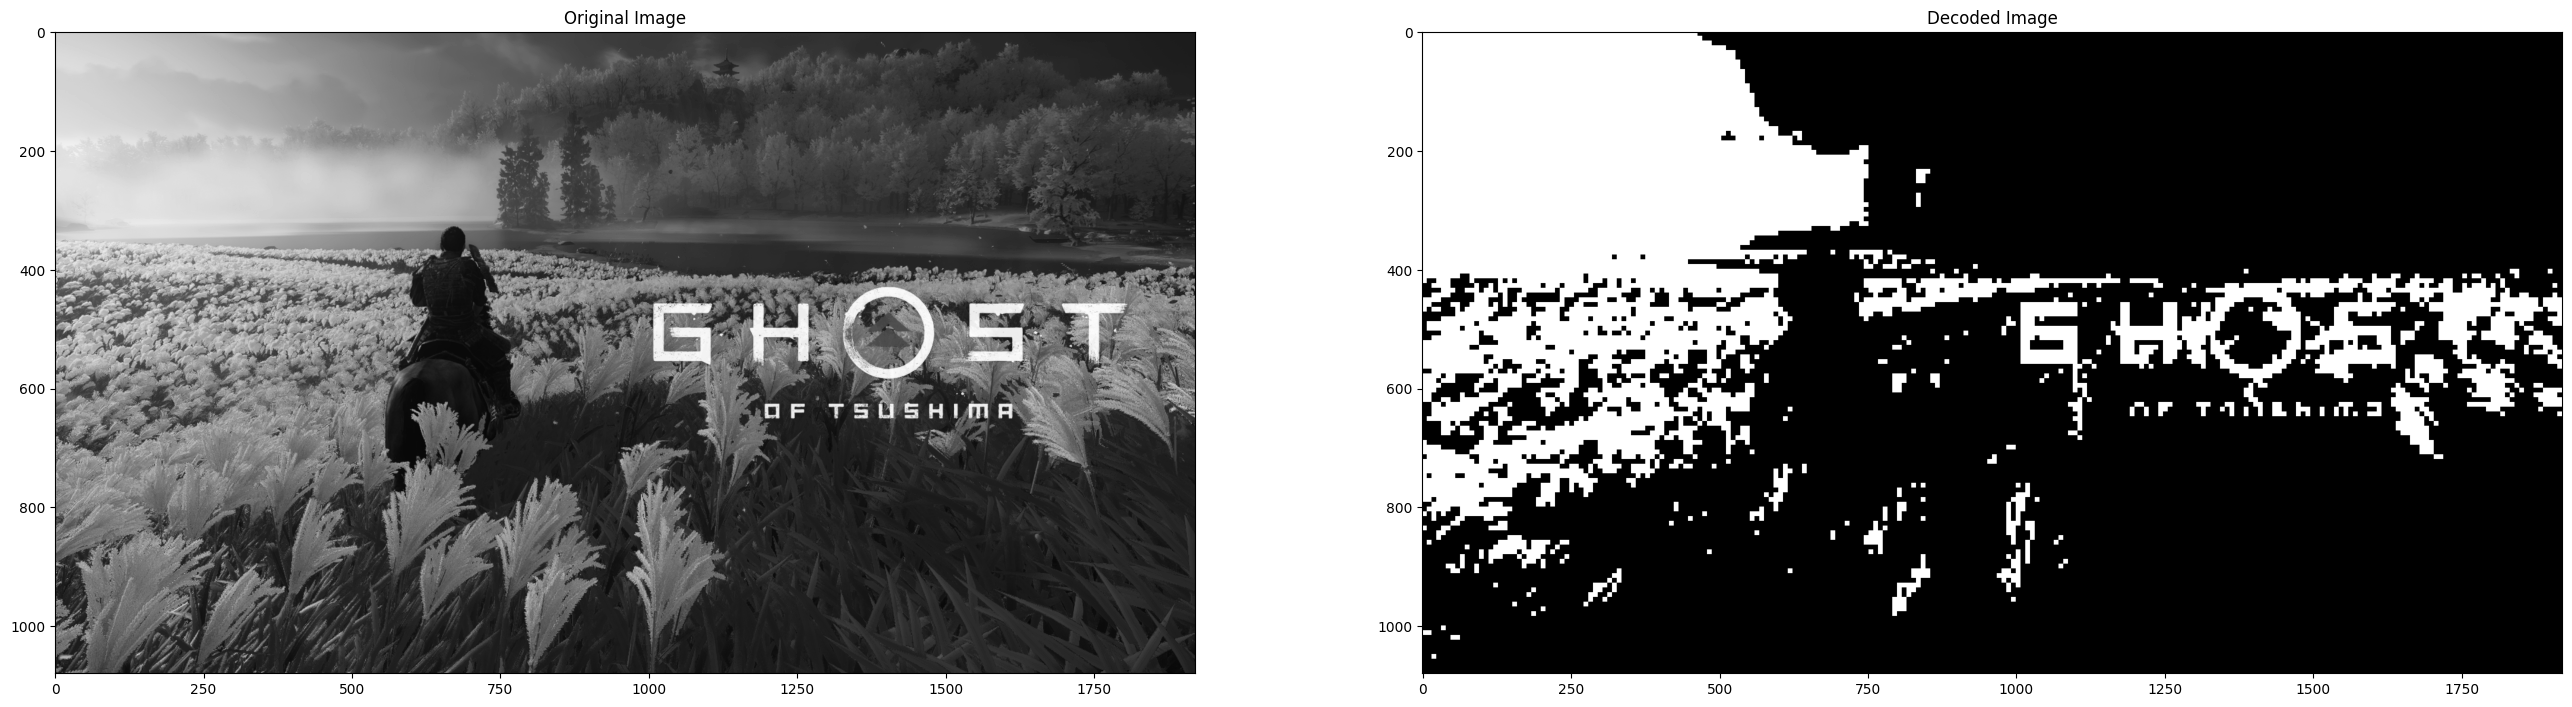

In [55]:
# Display images
plt.figure(figsize=(50, 50))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(decoded_image,
 cmap='gray')
plt.title('Decoded Image')

plt.show()

In [ ]:
######################################################################## Huffman Encoding ######################################################################################

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [57]:
class Node:
    def __init__(self, value, freq):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

def build_huffman_tree(frequencies):
    nodes = [Node(value, freq) for value, freq in frequencies.items()]
    while len(nodes) > 1:
        nodes.sort(key=lambda x: x.freq)
        left = nodes.pop(0)
        right = nodes.pop(0)
        parent = Node(None, left.freq + right.freq)

        parent.left = left
        parent.right = right
        nodes.append(parent)

    return nodes[0]

def build_huffman_codes(root):
    codes = {}
    def traverse(node, code=""):
        if node.value is not None:
            codes[node.value] = code
        else:
            traverse(node.left, code + "0")
            traverse(node.right, code + "1")
    traverse(root)
    return codes

def encode_image(image, codes):
    encoded_string = "".join([codes[pixel] for pixel in image.flatten()])
    return encoded_string

def decode_image(encoded_string, codes, shape):
    reverse_codes = {code: value for value, code in codes.items()}
    current_code = ""
    decoded_data = []
    for bit in encoded_string:
        current_code += bit
        if current_code in reverse_codes:
            decoded_data.append(reverse_codes[current_code])
            current_code = ""
    return np.array(decoded_data).reshape(shape)

def calculate_rmse(original_image, reconstructed_image):
    return np.sqrt(np.mean((original_image - reconstructed_image) ** 2))

In [58]:
# Load a grayscale image
image = plt.imread('GHOST OF TSUSHIMA.png')
if len(image.shape) > 2:
    image = np.mean(image, axis=2)  # Convert to grayscale if necessary

In [59]:
# Calculate pixel frequencies
frequencies = Counter(image.flatten())

In [60]:
# Build Huffman tree and codes
tree = build_huffman_tree(frequencies=frequencies)
codes = build_huffman_codes(tree)

In [61]:
# Encode and decode the image
encoded_image = encode_image(image, codes)
decoded_image = decode_image(encoded_image, codes, image.shape)

In [62]:
# Calculate compression ratio
original_size = image.size * np.dtype(image.dtype).itemsize
encoded_size = len(encoded_image) / 8  # Assuming 8 bits per character in the encoded string
compression_ratio = original_size / encoded_size

In [63]:
# Calculate RMSE
rmse = calculate_rmse(image, decoded_image)

In [64]:
# Display results
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"RMSE: {rmse:.2f}")

Compression Ratio: 3.45
RMSE: 0.00


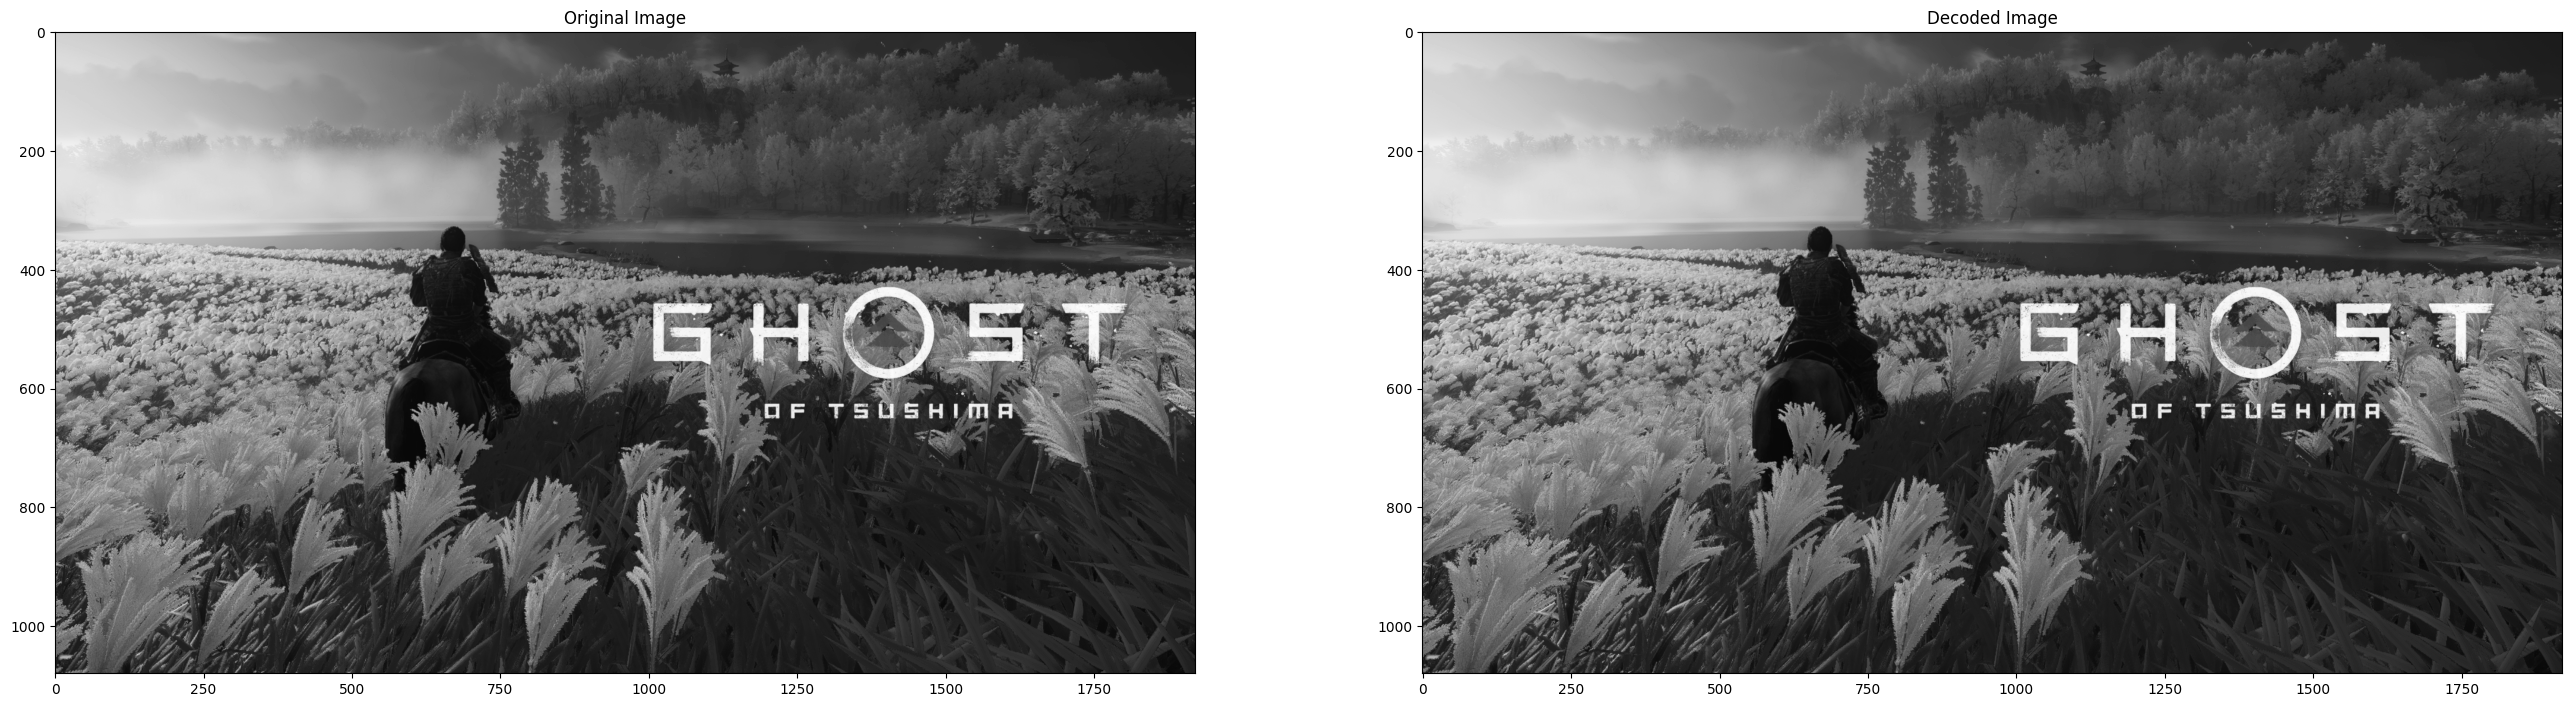

In [65]:
# Display images
plt.figure(figsize=(50, 50))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(decoded_image,
 cmap='gray')
plt.title('Decoded Image')

plt.show()

In [ ]:
############################################################################ LZW Encoding ######################################################################################

In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def lzw_encode(image):
    # Convert image to integers if it contains floats
    if image.dtype.kind == 'f':
        image = (image * 255).astype(np.uint8)

    dictionary = {str(i) + "_": i for i in range(256)}  # Initialize dictionary with single pixels including "_"
    next_code = 256
    current_string = ""
    encoded_data = []

    for pixel in image.flatten():
        next_string = current_string + str(pixel) + "_"  # Using "_" as a separator
        if next_string in dictionary:
            current_string = next_string
        else:
            encoded_data.append(dictionary[current_string])  # Encode the previous string
            dictionary[next_string] = next_code
            next_code += 1
            current_string = str(pixel) + "_"  # Start a new string

    encoded_data.append(dictionary[current_string])  # Encode the last string
    return encoded_data

In [74]:
# Load a grayscale image
image = plt.imread('GHOST OF TSUSHIMA.png')
if len(image.shape) > 2:
    image = np.mean(image, axis=2)  # Convert to grayscale if necessary

In [75]:
# Encode the image
encoded_image = lzw_encode(image)

In [76]:
# Calculate RMSE
rmse = calculate_rmse(image, decoded_image)

In [77]:
# Display results
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"RMSE: {rmse:.2f}")

Compression Ratio: 3.45
RMSE: 0.00


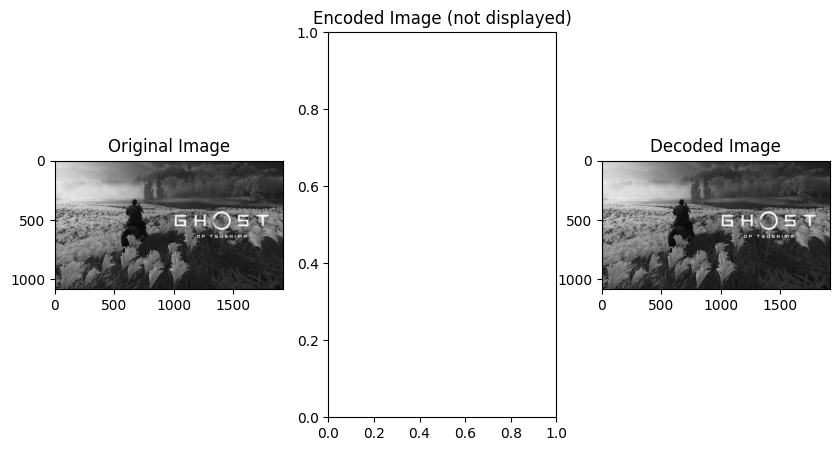

In [79]:
# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.title('Encoded Image (not displayed)')
#Why isn't the encoded image displayed?

#In the LZW encoding example, the encoded image is a list of integers representing codes.
#These codes don't directly translate to a visual representation like the original or decoded images.
#Displaying them as an image wouldn't be meaningful or visually interpretable.

#Instead of trying to display the encoded data, the code simply reserves a space for it
#in the subplot grid and puts a title to explain why it's empty.
#This helps maintain a consistent layout with the original and decoded images for comparison.

plt.subplot(1, 3, 3)
plt.imshow(decoded_image, cmap='gray')
plt.title('Decoded Image')

plt.show()

In [ ]:
##################################################################### Run-Length Encoding ######################################################################################

In [80]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
def run_length_encode(image):
  encoded_data = []
  current_pixel = image[0, 0]
  current_run = 0  # Initialize current_run to 0 instead of 1

  for row in image:
    for pixel in row:
      if pixel == current_pixel:
        current_run += 1
      else:
        encoded_data.append((current_pixel, current_run))
        current_pixel = pixel
        current_run = 1  # Reset current_run to 1 when a new pixel is encountered

  encoded_data.append((current_pixel, current_run))  # Append the last run

  return encoded_data

def run_length_decode(encoded_data, shape):
  decoded_data = []
  for pixel_value, run_length in encoded_data:
    decoded_data.extend([pixel_value] * run_length)
  return np.array(decoded_data).reshape(shape)

def calculate_rmse(original_image, reconstructed_image):
  return np.sqrt(np.mean((original_image - reconstructed_image) ** 2))

In [86]:
# Load a grayscale image
image = plt.imread('GHOST OF TSUSHIMA.png')
if len(image.shape) > 2:
  image = np.mean(image, axis=2)  # Convert to grayscale if necessary

In [87]:
# Encode and decode the image
encoded_image = run_length_encode(image)
decoded_image = run_length_decode(encoded_image, image.shape)

In [88]:
# Calculate compression ratio
original_size = image.size * np.dtype(image.dtype).itemsize
encoded_size = len(encoded_image) * (np.dtype(np.int32).itemsize + np.dtype(np.int32).itemsize)  # Assuming pixel value and run length are stored as integers
compression_ratio = original_size / encoded_size

In [89]:
# Calculate RMSE
rmse = calculate_rmse(image, decoded_image)

In [90]:
# Display results
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"RMSE: {rmse:.2f}")

Compression Ratio: 0.56
RMSE: 0.00


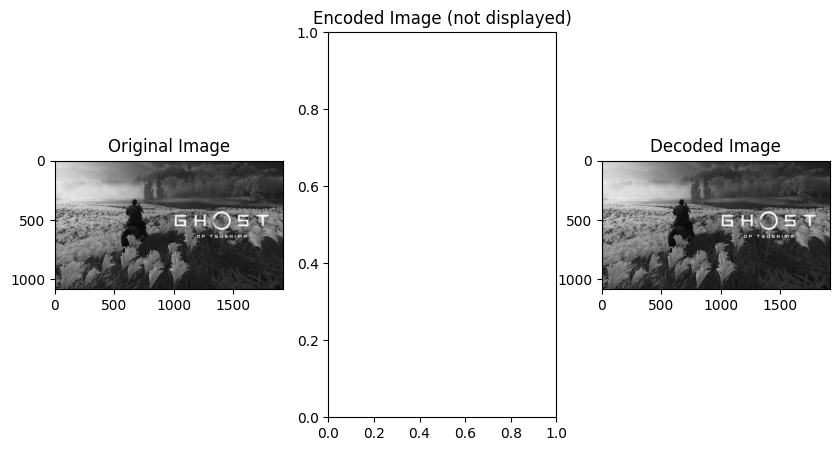

In [91]:
# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.title('Encoded Image (not displayed)')
#The encoded image is not displayed because it's not in a format that can be easily visualized.
#The code reserves a space for it in the plot layout for consistency but explicitly mentions that it's not displayed to avoid confusion.

plt.subplot(1, 3, 3)
plt.imshow(decoded_image, cmap='gray')
plt.title('Decoded Image')

plt.show()

In [ ]:
##################################################################### Arithmetic Coding ########################################################################################

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [102]:
def arithmetic_decode(encoded_message, probabilities, length, shape):
    low = 0.0
    high = 1.0
    range_ = 1.0
    decoded_data = []

    # Iterate for the expected number of pixels in the image
    for _ in range(shape[0] * shape[1]):
        for symbol, prob in probabilities.items():
            if low + range_ * prob > encoded_message:
                decoded_data.append(symbol)
                high = low + range_ * prob
                break
            else:
                low = low + range_ * prob

        range_ = high - low
        # Check if range_ is too small and handle it
        if range_ < 1e-10:  # Set a threshold for the minimum range
            range_ = 1e-10  # If it's too small, set it to a small non-zero value

    return np.array(decoded_data).reshape(shape)

In [103]:
# Load a grayscale image
image = plt.imread('GHOST OF TSUSHIMA.png')
if len(image.shape) > 2:
    image = np.mean(image, axis=2)  # Convert to grayscale if necessary

In [104]:
# Build probability table
probabilities = build_probability_table(image)

In [105]:
# Encode and decode the image
encoded_message, encoded_length = arithmetic_encode(image, probabilities)
decoded_image = arithmetic_decode(encoded_message, probabilities, encoded_length, image.shape)

In [106]:
# Calculate compression ratio
original_size = image.size * np.dtype(image.dtype).itemsize
compression_ratio = original_size * 8 / encoded_length  # 8 bits per byte

In [107]:
# Calculate RMSE
rmse = calculate_rmse(image, decoded_image)

In [108]:
# Display results
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"RMSE: {rmse:.2f}")

Compression Ratio: 1951623.53
RMSE: 0.38


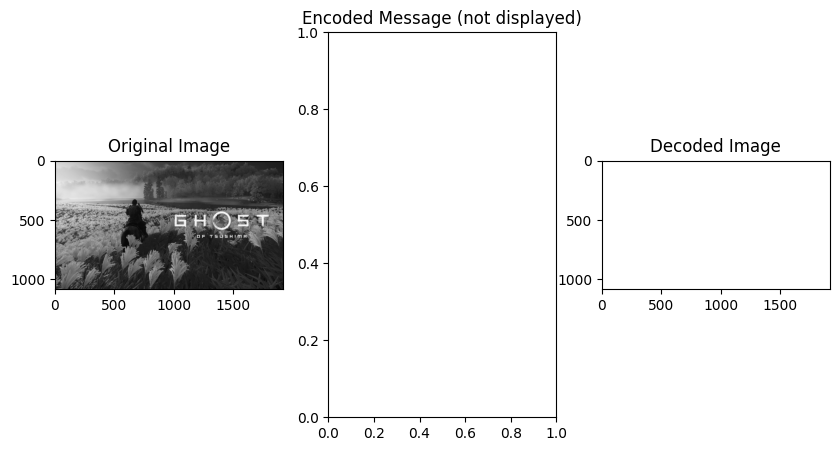

In [110]:
# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.title('Encoded Message (not displayed)')

plt.subplot(1, 3, 3)
plt.imshow(decoded_image, cmap='gray')
plt.title('Decoded Image')

plt.show()